# COSMOS Visual Zoobot Evaluation

This notebook compares Zoobot predictions against the saved COSMOS-Web visual labels. Place both `test_set_*.csv` (model probabilities) and `test_catalog.csv` (ground-truth labels) on your local machine and set their paths below.

## 1. Configure file locations

Set the local paths to the exported prediction CSV (`test_set_*.csv`) and the `test_catalog.csv` containing the ground-truth labels. No remote catalogs or stamps are required.

In [139]:
from pathlib import Path

PREDICTIONS_CSV = Path("/Users/marchuertascompany/Documents/data/COSMOS-Web/zoobot/ilbert/binary/test_set_euclid_binary.csv")
GROUND_TRUTH_CSV = Path("/Users/marchuertascompany/Documents/data/COSMOS-Web/zoobot/ilbert/binary/test_catalog.csv")


In [140]:
import sys
from pathlib import Path

repo_root = Path("/Users/marchuertascompany/Documents/python_scripts/cosmosweb_lowQ")
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from moprhology.zoobot import train_on_cosmos_visual as cosmos
from IPython.display import display

In [141]:
predictions = pd.read_csv(PREDICTIONS_CSV)
prob_cols = [col for col in predictions.columns if col.startswith('p_')]
if not prob_cols:
    raise ValueError("No probability columns (prefixed with 'p_') found in predictions file.")

truth = pd.read_csv(GROUND_TRUTH_CSV)
if 'id_str' not in truth.columns:
    raise ValueError("Ground-truth catalog must contain an 'id_str' column.")

predictions.head()


,p_NOT_DISTURBED,p_DISTURBED,id_str
0,0.172307,0.827693,7920
1,0.996514,0.003486,1640
2,0.073464,0.926536,12894
3,0.935743,0.064257,5986
4,0.690393,0.309607,2033


## 2. Attach class predictions

Derive the most probable class for each galaxy and the associated confidence.

In [142]:
label_names = [col[2:] for col in prob_cols]
prob_matrix = predictions[prob_cols].to_numpy()
pred_indices = prob_matrix.argmax(axis=1)
pred_labels = [label_names[i] for i in pred_indices]
pred_confidence = prob_matrix.max(axis=1)

predictions['pred_label'] = pred_labels
predictions['pred_idx'] = pred_indices
predictions['pred_confidence'] = pred_confidence

predictions[['id_str', 'pred_label', 'pred_confidence'] + prob_cols].head()


,id_str,pred_label,pred_confidence,p_NOT_DISTURBED,p_DISTURBED
0,7920,DISTURBED,0.827693,0.172307,0.827693
1,1640,NOT_DISTURBED,0.996514,0.996514,0.003486
2,12894,DISTURBED,0.926536,0.073464,0.926536
3,5986,NOT_DISTURBED,0.935743,0.935743,0.064257
4,2033,NOT_DISTURBED,0.690393,0.690393,0.309607


## 3. Merge with ground truth (if available)

Metrics are computed only when true labels are provided. Set `GROUND_TRUTH_CSV` or enable the rebuild block above.

In [143]:
truth_cols = ['id_str', 'label'] if 'label' in truth.columns else ['id_str', 'true_label']
merged = predictions.merge(truth[truth_cols], on='id_str', how='inner', suffixes=('', '_true'))
label_to_index = {name: idx for idx, name in enumerate(label_names)}

if 'label' in merged.columns:
    if merged['label'].dtype == object and merged['label'].isin(label_to_index.keys()).all():
        merged['true_label'] = merged['label']
        merged['true_idx'] = merged['true_label'].map(label_to_index)
    else:
        merged['true_idx'] = merged['label'].astype(int)
        merged['true_label'] = merged['true_idx'].map(lambda idx: label_names[idx])
elif 'true_label' in merged.columns:
    merged['true_idx'] = merged['true_label'].map(label_to_index)
else:
    raise ValueError("Ground-truth data must contain a 'label' (int) or 'true_label' (string) column.")

print(f"Merged {len(merged)} rows with ground truth out of {len(predictions)} predictions.")
merged.head()

Merged 1346 rows with ground truth out of 1214 predictions.


,p_NOT_DISTURBED,p_DISTURBED,id_str,pred_label,pred_idx,pred_confidence,label,true_idx,true_label
0,0.172307,0.827693,7920,DISTURBED,1,0.827693,1,1,DISTURBED
1,0.996514,0.003486,1640,NOT_DISTURBED,0,0.996514,0,0,NOT_DISTURBED
2,0.073464,0.926536,12894,DISTURBED,1,0.926536,1,1,DISTURBED
3,0.935743,0.064257,5986,NOT_DISTURBED,0,0.935743,0,0,NOT_DISTURBED
4,0.690393,0.309607,2033,NOT_DISTURBED,0,0.690393,0,0,NOT_DISTURBED


## 4. Classification metrics

In [144]:
if 'merged' not in globals():
    raise RuntimeError("Run the merge cell above before computing metrics.")

acc = accuracy_score(merged['true_idx'], merged['pred_idx'])
print(f"Overall accuracy: {acc:.4f}")
report = classification_report(
    merged['true_idx'],
    merged['pred_idx'],
    target_names=label_names,
    zero_division=0
)
print(report)

Overall accuracy: 0.7556
               precision    recall  f1-score   support

NOT_DISTURBED       0.75      0.83      0.79       739
    DISTURBED       0.76      0.67      0.71       607

     accuracy                           0.76      1346
    macro avg       0.76      0.75      0.75      1346
 weighted avg       0.76      0.76      0.75      1346



## 5. Confusion matrix

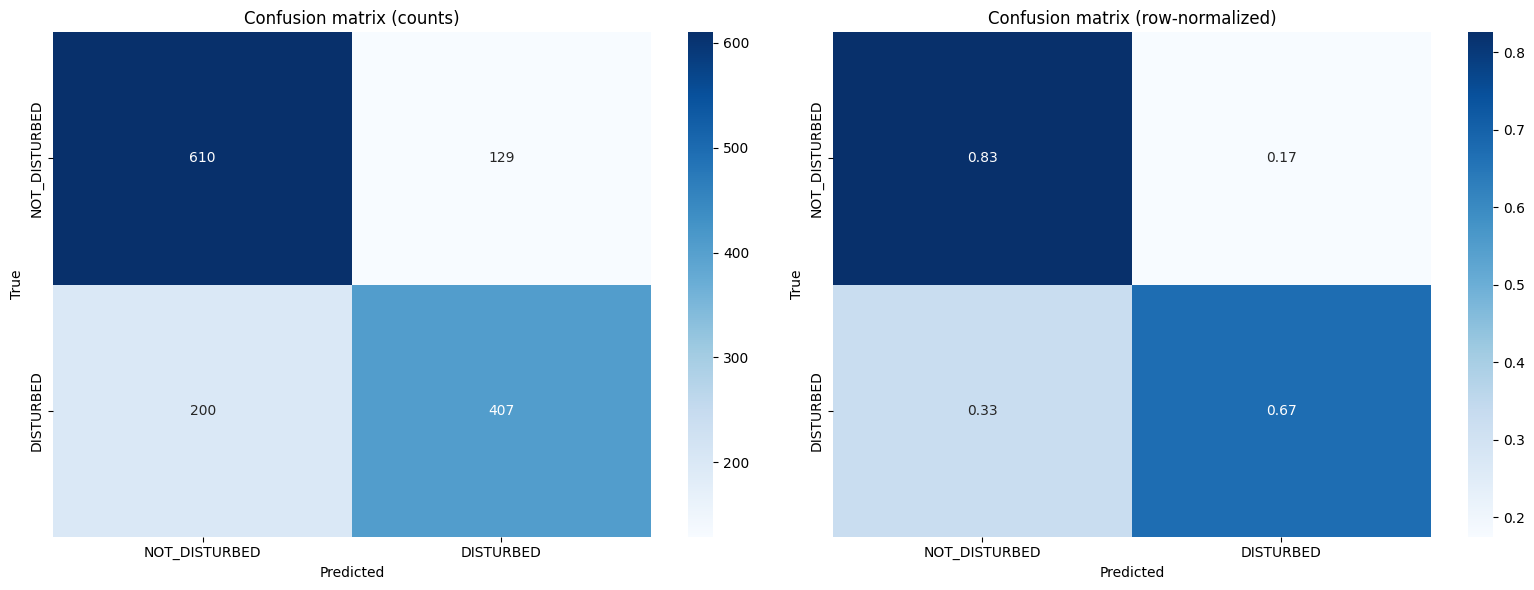

In [145]:
if 'merged' not in globals():
    raise RuntimeError("Run the merge cell above before plotting the confusion matrix.")

cm = confusion_matrix(
    merged['true_idx'],
    merged['pred_idx'],
    labels=list(range(len(label_names)))
)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0], xticklabels=label_names, yticklabels=label_names)
ax[0].set_title('Confusion matrix (counts)')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', ax=ax[1], xticklabels=label_names, yticklabels=label_names)
ax[1].set_title('Confusion matrix (row-normalized)')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('True')
plt.tight_layout()

## 6. Per-class confidence summary

In [146]:
per_class = (
    merged.groupby('true_label')
    .agg(
        support=('true_label', 'size'),
        accuracy=('pred_idx', lambda idx: np.mean(idx == merged.loc[idx.index, 'true_idx'])),
        mean_confidence=('pred_confidence', 'mean'),
        median_confidence=('pred_confidence', 'median')
    )
    .sort_values('support', ascending=False)
)
display(per_class)


,support,accuracy,mean_confidence,median_confidence
true_label,,,,
NOT_DISTURBED,739,0.825440,0.841850,0.885728
DISTURBED,607,0.670511,0.816583,0.858221


## 7. Inspect largest errors

In [147]:
prob_array = merged[prob_cols].to_numpy()
true_probs = prob_array[np.arange(len(merged)), merged['true_idx']]
errors = merged[merged['pred_label'] != merged['true_label']].copy()
errors['true_prob'] = true_probs[errors.index]
errors['confidence_gap'] = errors['pred_confidence'] - errors['true_prob']
display(errors.sort_values('pred_confidence', ascending=False).head(20)[
    ['id_str', 'true_label', 'pred_label', 'pred_confidence', 'true_prob', 'confidence_gap']
])


,id_str,true_label,pred_label,pred_confidence,true_prob,confidence_gap
1097,12864,DISTURBED,NOT_DISTURBED,0.999910,0.000090,0.999820
457,5552,DISTURBED,NOT_DISTURBED,0.999577,0.000423,0.999153
995,12452,DISTURBED,NOT_DISTURBED,0.999497,0.000503,0.998994
426,2447,DISTURBED,NOT_DISTURBED,0.999290,0.000710,0.998580
678,13438,DISTURBED,NOT_DISTURBED,0.999266,0.000734,0.998531
1138,2078,NOT_DISTURBED,DISTURBED,0.999002,0.000998,0.998004
453,2458,DISTURBED,NOT_DISTURBED,0.998157,0.001843,0.996315
916,10080,NOT_DISTURBED,DISTURBED,0.998088,0.001912,0.996175
937,9181,DISTURBED,NOT_DISTURBED,0.997630,0.002370,0.995260
735,12769,NOT_DISTURBED,DISTURBED,0.991895,0.008105,0.983791


## 8. Export confusion samples for stamp galleries

Specify which true/predicted combinations to export (list of tuples) and the
number of samples per cell. The resulting CSV can be used with
`moprhology.zoobot.plot_confusion_examples`.


In [ ]:
from pathlib import Path

desired_pairs = [
    (label_names[0], label_names[0]),
    (label_names[0], label_names[1]),
    (label_names[1], label_names[0]),
    (label_names[1], label_names[1]),
]

samples_per_pair = 50
export_csv = Path("confusion_samples_binary.csv")

records = []
for true_label, pred_label in desired_pairs:
    subset = merged[(merged['true_label'] == true_label) & (merged['pred_label'] == pred_label)]
    if subset.empty:
        continue
    take = min(samples_per_pair, len(subset))
    records.append(subset.sample(n=take, random_state=42))

if records:
    exported = pd.concat(records).drop_duplicates(subset=["id_str"])
    export_cols = ['id_str', 'true_label', 'pred_label']
    optional_cols = ['pred_confidence', 'filter_used', 'file_loc']
    available = [col for col in optional_cols if col in exported.columns]
    exported[export_cols + available].to_csv(export_csv, index=False)
    print(f"Saved {len(exported)} sample rows to {export_csv} with columns {export_cols + available}")
else:
    print("No matching confusion pairs found; CSV not written.")


Saved 200 sample rows to confusion_samples_binary.csv with columns ['id_str', 'true_label', 'pred_label', 'pred_confidence']
